# Object Segmentation and Detection

The objective of this use case is to showcase the use of prompt object segmentation and detection.

## Prompt Object Segmentation using SAM and Sentinel-2 Images

1- Create an ROI to download Sentinel-2 images using QGIS in EPSG 4326.

2- Create a bounding box around the object of interest.

3- Perform prompt segmentation with SAM API.

4- Visualize the obtained results.


### Required imports

In [87]:
import os
import json
import requests
import glob
import gdown
import zipfile
import numpy as np
import geopandas as gpd
import tifffile as tiff
from matplotlib import pyplot as plt
from matplotlib import patches
from utils import geometry_to_coords,save_image_from_url,geometry_to_xy,geographic_to_pixel_bbox,get_filename_from_url,download_txtfile_from_url,obb_to_aabb,read_annotation_file

ImportError: cannot import name 'obb_to_aabb' from 'utils' (/Users/syam/Documents/code/eo4eu/igarss-tutorial/igarss2024/utils.py)

### URLs of the APIs to be used

In [3]:
sentinel_api = "http://sentinel-api-test.dev.apps.eo4eu.eu"
sam_api = "http://sam-api-test.dev.apps.eo4eu.eu"
od_api = "http://od-api-test.dev.apps.eo4eu.eu"

### Headers for the API requests

In [4]:
headers = {
    'accept': 'application/json',
    'access-token': 'YOUR API KEY',
    'Content-Type': 'application/json'
}

### Data directory

In [5]:
data_path = "data/object_detection"
os.makedirs(data_path,exist_ok=True)

### WORKFLOW1 Prompt Image Segmentation using SAM API and Sentinel-2 Images

#### Create a shapefile on QGIS to define the ROI in EPSG 4326. Then read this file and convert the geomerty to xy coordinates to prepare for the API call

In [20]:
roi_gdf = gpd.read_file("data/object_detection/sentinel_roi/palm_roi.shp")
geometry = roi_gdf.geometry.iloc[0]
coords = geometry_to_coords(geometry)
coords

[[54.939335770738644, 24.963109041667348],
 [54.939335770738644, 25.06510904166735],
 [55.04333577073864, 25.06510904166735],
 [55.04333577073864, 24.963109041667348],
 [54.939335770738644, 24.963109041667348]]

#### Call the Sentinel API to get RGB images of the ROI. The required parameters are:
- Geometry
- Start date
- End date
- Cloud cover
- Index

In [21]:
data = {
    "geometry":coords,
    "start_date":"2023-06-05",
    "end_date":"2023-06-08",
    "cloud_cover":"10",
    "index":"RGB"  
}
response = requests.post(os.path.join(sentinel_api,"api/v1/s2l2a/roi/process"), headers=headers, json=data)
print(response.text)
task_id = json.loads(response.content.decode())

{"task_id":"2cd68830-1190-420a-8baa-ac8850d72199"}


#### Monitor task status

In [26]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(sentinel_api,"api/v1/task/status"), headers=headers, params=params)
print(response.text)

{"task_id":"2cd68830-1190-420a-8baa-ac8850d72199","state":"SUCCESS","result":"[{'image': 'L2/tiles/40/R/BN/S2B_MSIL2A_20230607T064629_N0509_R020_T40RBN_20230607T093051.SAFE', 'processed': True, 'url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/2cd68830-1190-420a-8baa-ac8850d72199/T40RBN_20230607T064629_RGB.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=SI9ox3G56%2BCDro25s%2Bf35KmoJks%3D&Expires=1716505761', 'uri': 's3://MoBucket/2cd68830-1190-420a-8baa-ac8850d72199/T40RBN_20230607T064629_RGB.tif'}, {'image': 'L2/tiles/39/R/ZH/S2B_MSIL2A_20230607T064629_N0509_R020_T39RZH_20230607T093051.SAFE', 'processed': True, 'url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/2cd68830-1190-420a-8baa-ac8850d72199/T39RZH_20230607T064629_RGB.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=8d3hxTB7DBu613YrqA2DIAu8m5o%3D&Expires=1716505764', 'uri': 's3://MoBucket/2cd68830-1190-420a-8baa-ac8850d72199/T39RZH_20230607T064629_RGB.tif'}, {'image': 'L2/tiles/40/R/

#### Get results using task ID

In [27]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(sentinel_api,"api/v1/s2l2a/roi/process"), headers=headers, params=params)
results = response.json()
print (results)

{'results': [{'image': 'L2/tiles/40/R/BN/S2B_MSIL2A_20230607T064629_N0509_R020_T40RBN_20230607T093051.SAFE', 'processed': True, 'url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/2cd68830-1190-420a-8baa-ac8850d72199/T40RBN_20230607T064629_RGB.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=SI9ox3G56%2BCDro25s%2Bf35KmoJks%3D&Expires=1716505761', 'uri': 's3://MoBucket/2cd68830-1190-420a-8baa-ac8850d72199/T40RBN_20230607T064629_RGB.tif'}, {'image': 'L2/tiles/39/R/ZH/S2B_MSIL2A_20230607T064629_N0509_R020_T39RZH_20230607T093051.SAFE', 'processed': True, 'url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/2cd68830-1190-420a-8baa-ac8850d72199/T39RZH_20230607T064629_RGB.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=8d3hxTB7DBu613YrqA2DIAu8m5o%3D&Expires=1716505764', 'uri': 's3://MoBucket/2cd68830-1190-420a-8baa-ac8850d72199/T39RZH_20230607T064629_RGB.tif'}, {'image': 'L2/tiles/40/R/CN/S2B_MSIL2A_20230607T064629_N0509_R020_T40RCN_20230607T093051.SA

#### Save results from signed URL to local files

In [28]:
rgb_output_path = os.path.join(data_path,"sentinel_rgb_images")
os.makedirs(rgb_output_path,exist_ok=True)

In [29]:
list_downloaded_imgs = []
for res in results["results"]:
    file_name = get_filename_from_url(res["url"])
    output_file_path = os.path.join(rgb_output_path,file_name)
    save_image_from_url(res["url"],output_file_path)
    list_downloaded_imgs.append(output_file_path)

Image successfully saved to data/object_detection/sentinel_rgb_images/T40RBN_20230607T064629_RGB.tif
Image successfully saved to data/object_detection/sentinel_rgb_images/T39RZH_20230607T064629_RGB.tif
Image successfully saved to data/object_detection/sentinel_rgb_images/T40RCN_20230607T064629_RGB.tif


#### Visualize results

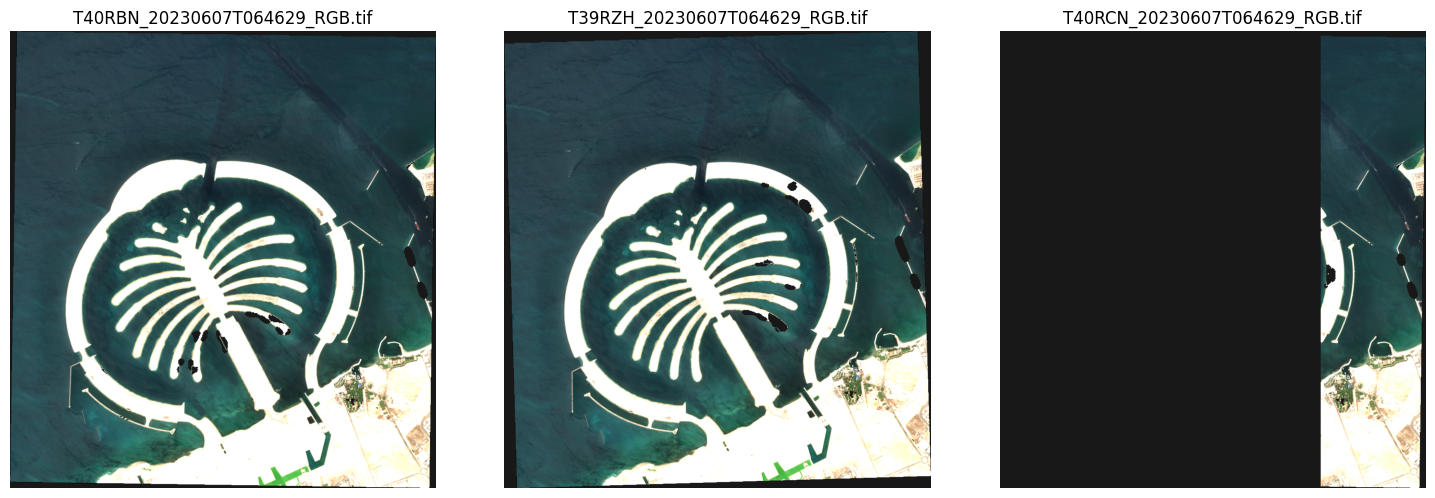

In [30]:
num_images = len(list_downloaded_imgs)
cols = 3  
rows = (num_images // cols) + (num_images % cols > 0) 
plt.figure(figsize=(15, 5 * rows)) 
for i, image_path in enumerate(list_downloaded_imgs):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue
    img = tiff.imread(image_path)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.axis('off') 
    plt.title(os.path.basename(image_path))
plt.tight_layout()
plt.show()

#### Read the bounding box and convert it to x_min,y_min,x_max,y_max

In [31]:
bbox_gdf = gpd.read_file("data/object_detection/sentinel_roi/bbox.shp")
list_bboxes = geometry_to_xy(bbox_gdf)
list_bboxes

[[54.94884426946525,
  24.969402298985127,
  55.034844269465246,
  25.04040229898513]]

#### Convert geographic coordinates to pixel coordinates

In [35]:
img = tiff.imread(list_downloaded_imgs[0])
roi_bbox = geometry_to_xy(roi_gdf)[0]
pixel_bboxes = geographic_to_pixel_bbox(np.array(list_bboxes),img.shape[1],img.shape[0],roi_bbox[1],
            roi_bbox[3],
            roi_bbox[0],
            roi_bbox[2])
pixel_bboxes

array([[  97,  277,  980, 1076]])

#### Visualize the image and the pixel bounding box for verification

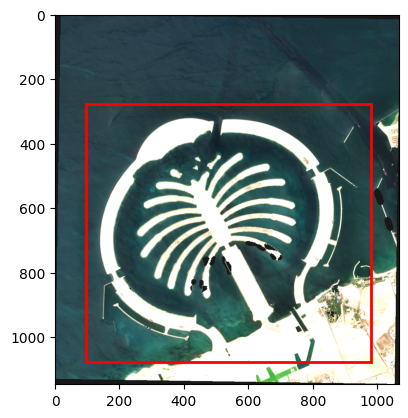

In [36]:
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(img.astype("uint8"))

# Add the bounding boxes
for box in pixel_bboxes:
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Display the plot
plt.show()

#### Segment the image with SAM API using the bounding box as a prompt

In [37]:
rgb_img_uri = results["results"][0]["uri"]
data = {
    "list_images": [
        {
            "image_name": os.path.basename(rgb_img_uri),
            "image_uri": rgb_img_uri,
            "bboxes": pixel_bboxes.tolist(),
            "points": None,
            "labels": None
        },
    ]
}
response = requests.post(os.path.join(sam_api,"api/v1/prompt"),headers=headers,json=data)
print (response.text)
task_id = json.loads(response.content.decode())

{"task_id":"976afade-9169-4033-9d4c-d254b0a69c33"}


#### Monitor task status

In [40]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(sam_api,"api/v1/task/status"), headers=headers, params=params)
print(response.text)

{"task_id":"976afade-9169-4033-9d4c-d254b0a69c33","state":"SUCCESS","result":"[{'image_uri': 's3://MoBucket/2cd68830-1190-420a-8baa-ac8850d72199/T40RBN_20230607T064629_RGB.tif', 'processed': True, 'png_result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/976afade-9169-4033-9d4c-d254b0a69c33/T40RBN_20230607T064629_RGB_bbox_mask.png?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=UpraB%2BXIao8WaCXk7vRpZl%2Blbw4%3D&Expires=1716506175', 'png_result_uri': 's3://MoBucket/976afade-9169-4033-9d4c-d254b0a69c33/T40RBN_20230607T064629_RGB_bbox_mask.png', 'tif_result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/976afade-9169-4033-9d4c-d254b0a69c33/T40RBN_20230607T064629_RGB_bbox_mask.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=5S28l6MDpKYsKS%2FPRs1C04mUm6k%3D&Expires=1716506175', 'tif_result_uri': 's3://MoBucket/976afade-9169-4033-9d4c-d254b0a69c33/T40RBN_20230607T064629_RGB_bbox_mask.tif'}]"}


#### Get the results

In [41]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(sam_api,"api/v1/prompt"), headers=headers, params=params)
results = response.json()
print (results)

{'results': [{'image_uri': 's3://MoBucket/2cd68830-1190-420a-8baa-ac8850d72199/T40RBN_20230607T064629_RGB.tif', 'processed': True, 'png_result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/976afade-9169-4033-9d4c-d254b0a69c33/T40RBN_20230607T064629_RGB_bbox_mask.png?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=UpraB%2BXIao8WaCXk7vRpZl%2Blbw4%3D&Expires=1716506175', 'png_result_uri': 's3://MoBucket/976afade-9169-4033-9d4c-d254b0a69c33/T40RBN_20230607T064629_RGB_bbox_mask.png', 'tif_result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/976afade-9169-4033-9d4c-d254b0a69c33/T40RBN_20230607T064629_RGB_bbox_mask.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=5S28l6MDpKYsKS%2FPRs1C04mUm6k%3D&Expires=1716506175', 'tif_result_uri': 's3://MoBucket/976afade-9169-4033-9d4c-d254b0a69c33/T40RBN_20230607T064629_RGB_bbox_mask.tif'}]}


#### Save results to local file

In [42]:
segmentation_output_path = os.path.join(data_path,"sam_segmentation")
os.makedirs(segmentation_output_path,exist_ok=True)

In [112]:
sam_output_tif_path = os.path.join(segmentation_output_path,"prompt_mask_bbox.tif")
save_image_from_url(results["results"][0]["tif_result_url"],sam_output_tif_path)

#### Visualize the results

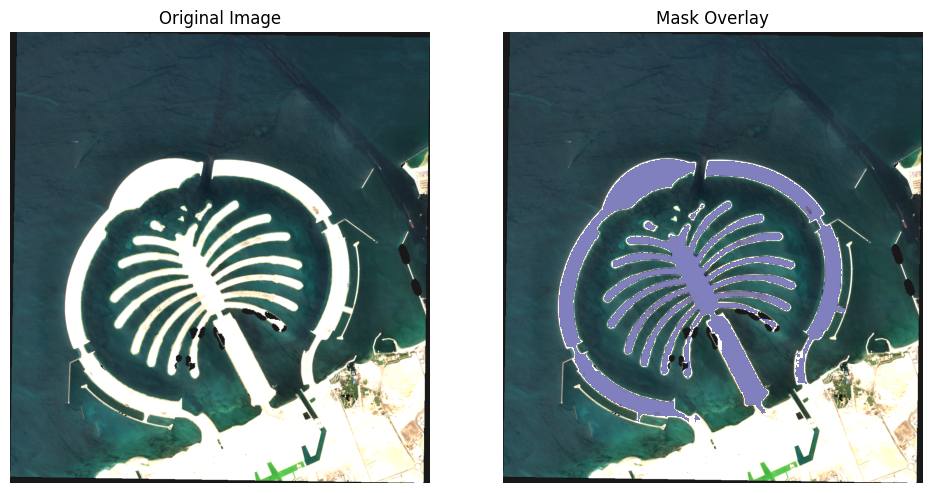

In [113]:
rgb_img = tiff.imread(list_downloaded_imgs[0])
msk_img = tiff.imread(sam_output_tif_path)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img.astype("uint8"))
plt.axis('off')
plt.title('Original Image')
msk_img[msk_img==0] = np.nan
plt.subplot(1, 2, 2)
plt.imshow(rgb_img.astype("uint8"))
plt.imshow(msk_img, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Mask Overlay')
plt.tight_layout()
plt.show()

### WORKFLOW 2 Object Detection using OD API and VHR Images

#### Download the dataset from GDrive

In [63]:
file_id = "1DA3lDUjWGgzTli2ksRkDpCMAwX_INIPe"
zip_destination = "data/object_detection/tiles.zip"
os.makedirs(os.path.dirname(zip_destination), exist_ok=True)
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, destination, quiet=False)
with zipfile.ZipFile(zip_destination, 'r') as zip_ref:
    zip_ref.extractall(data_path)

#### Get list of images from local directory. These images are duplicated on S3 storage to be found by the model and avoid uploading them again

In [66]:
list_imgs = glob.glob(os.path.join(data_path, 'tiles/*.tif'))

In [67]:
len(list_imgs)

625

#### Visualize some examples of these images

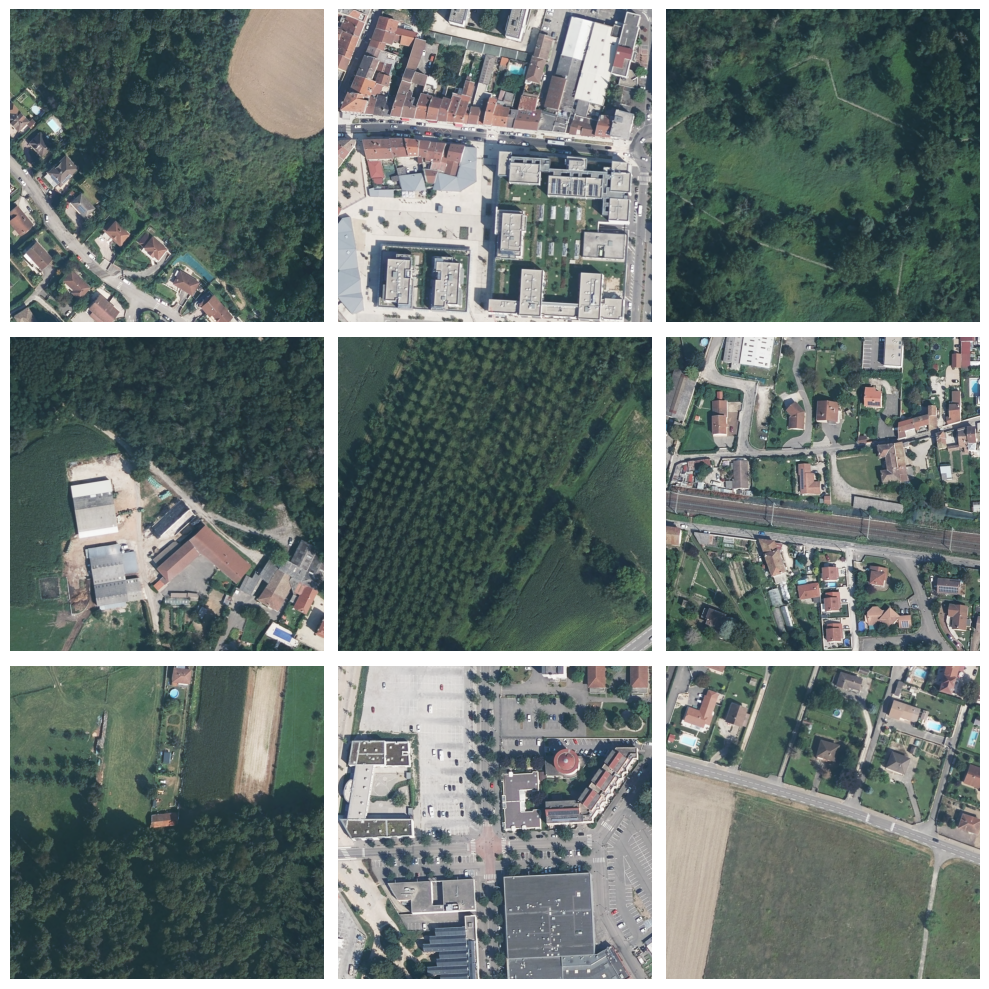

In [73]:
num_images = 9
random_indices = np.random.choice(len(list_imgs), num_images, replace=False)
random_images = [tiff.imread(list_imgs[i]) for i in random_indices]
figsize = (10, 10)
fig, axes = plt.subplots(3, 3, figsize=figsize)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.ravel()
for i in range(num_images):
    axes[i].imshow(random_images[i], cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

#### Send request to the OD API to detect all objects that can be detected by the model

In [74]:
classes = {
        "plane": 0,
        "ship": 1,
        "storage-tank": 2,
        "baseball-diamond": 3,
        "tennis-court": 4,
        "basketball-court": 5,
        "ground-track-field": 6,
        "harbor": 7,
        "bridge": 8,
        "large-vehicle": 9,
        "small-vehicle": 10,
        "helicopter": 11,
        "roundabout": 12,
        "soccer-ball-field": 13,
        "swimming-pool": 14,
        "container-crane": 15,
        "airport": 16,
        "helipad": 17
      }
list_tasks = []
for i in range (0,len(list_imgs),5):
    img_files = list_imgs[i:i+5]
    img_files = [os.path.basename(img) for img in img_files]
    data = {"list_images":[{"image_uri":os.path.join("s3://MoBucket/yolov8-od",img),"classes":classes} for img in img_files]}
    response = requests.post(os.path.join(od_api,"api/v1/yolov8/obb/detect"),headers=headers,json=data)
    task_id = json.loads(response.content.decode())
    list_tasks.append(task_id["task_id"])

#### Monitoring the status of the tasks

In [76]:
for idx, task_id in enumerate(list_tasks):
    print (idx)
    params = {'task_id': task_id}
    response = requests.get(os.path.join(od_api,"api/v1/task/status"), headers=headers, params=params)
    print(response.text)

0
{"task_id":"5cb7e387-b16f-49c0-8e88-865fbd8c4a43","state":"SUCCESS","result":"[{'image_uri': 's3://MoBucket/yolov8-od/patch_299.tif', 'processed': True, 'result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/5cb7e387-b16f-49c0-8e88-865fbd8c4a43/patch_299.txt?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=M3m8A%2BKt%2FqHy6SgsLV2uPRY1HSE%3D&Expires=1716511793', 'result_uri': 's3://MoBucket/5cb7e387-b16f-49c0-8e88-865fbd8c4a43/patch_299.txt'}, {'image_uri': 's3://MoBucket/yolov8-od/patch_272.tif', 'processed': True, 'result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/5cb7e387-b16f-49c0-8e88-865fbd8c4a43/patch_272.txt?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=LVo8xP5IfYGlBchCTh%2B7myQuJrM%3D&Expires=1716511793', 'result_uri': 's3://MoBucket/5cb7e387-b16f-49c0-8e88-865fbd8c4a43/patch_272.txt'}, {'image_uri': 's3://MoBucket/yolov8-od/patch_514.tif', 'processed': True, 'result_url': None, 'result_uri': None}, {'image_uri': 's3://MoBucket

#### Save results to local files

In [77]:
bbox_output_path = "data/object_detection/vhr_bboxes"
os.makedirs(bbox_output_path,exist_ok=True)
for task in list_tasks:
    params = {'task_id': task}
    response = requests.get(os.path.join(od_api,"api/v1/yolov8/obb/detect"), headers=headers, params=params)
    results = response.json()
    results = results["results"]
    for res in results:
        result_url = res["result_url"]
        if result_url is not None:
            fname = get_filename_from_url(result_url)
            output_fname = os.path.join(bbox_output_path,fname)
            download_txtfile_from_url(result_url,output_fname)



File downloaded successfully as data/object_detection/vhr_bboxes/patch_299.txt
File downloaded successfully as data/object_detection/vhr_bboxes/patch_272.txt
File downloaded successfully as data/object_detection/vhr_bboxes/patch_266.txt
File downloaded successfully as data/object_detection/vhr_bboxes/patch_38.txt
File downloaded successfully as data/object_detection/vhr_bboxes/patch_110.txt
File downloaded successfully as data/object_detection/vhr_bboxes/patch_138.txt
File downloaded successfully as data/object_detection/vhr_bboxes/patch_2.txt
File downloaded successfully as data/object_detection/vhr_bboxes/patch_460.txt
File downloaded successfully as data/object_detection/vhr_bboxes/patch_474.txt
File downloaded successfully as data/object_detection/vhr_bboxes/patch_312.txt
File downloaded successfully as data/object_detection/vhr_bboxes/patch_313.txt
File downloaded successfully as data/object_detection/vhr_bboxes/patch_461.txt
File downloaded successfully as data/object_detection/v

#### Visualize the results using Dash Plotly

In [84]:
import colorsys
import io
import dash
from dash import dcc, html
import dash_daq as daq
from dash.dependencies import Input, Output
import os
import cv2
import base64
from PIL import Image
import numpy as np

CATEGORIES = {
    "plane": 0,
    "ship": 1,
    "storage-tank": 2,
    "baseball-diamond": 3,
    "tennis-court": 4,
    "basketball-court": 5,
    "ground-track-field": 6,
    "harbor": 7,
    "bridge": 8,
    "large-vehicle": 9,
    "small-vehicle": 10,
    "helicopter": 11,
    "roundabout": 12,
    "soccer-ball-field": 13,
    "swimming-pool": 14,
    "container-crane": 15,
    "airport": 16,
    "helipad": 17,
}

app = dash.Dash(__name__)

# Path to the directory containing images
image_directory = "data/object_detection/tiles"

# Path to the directory containing annotation files
annotation_directory = "data/object_detection/vhr_bboxes"


# Function to generate distinct colors for each class ID
def generate_class_colors(num_classes):
    hsv_colors = [(x * 1.0 / num_classes, 1.0, 1.0) for x in range(num_classes)]
    rgb_colors = [
        tuple(int(255 * y) for y in colorsys.hsv_to_rgb(*color)) for color in hsv_colors
    ]
    return rgb_colors


# Function to read annotation file
def read_annotation_file(annotation_path):
    with open(annotation_path, "r") as file:
        lines = file.readlines()
    annotations = []
    for line in lines:
        values = line.strip().split()
        category = values[0]
        x1, y1, x2, y2, x3, y3, x4, y4 = map(lambda val: float(val) * 1025, values[1:-1])
        annotations.append(
            {"class_id": int(category), "coordinates": [x1, y1, x2, y2, x3, y3, x4, y4]}
        )
    return annotations


# Function to generate image options and corresponding annotation paths
def get_image_options():
    images = []
    annotations_paths = []
    for filename in os.listdir(image_directory):
        if filename.endswith((".png", ".jpg", ".jpeg",".tif")):
            images.append(filename)
            annotation_filename = os.path.splitext(filename)[0] + ".txt"
            annotation_path = os.path.join(annotation_directory, annotation_filename)
            annotations_paths.append(annotation_path)
    return [
        {"label": image, "value": annotation_path}
        for image, annotation_path in zip(images, annotations_paths)
    ]


# Number of classes
num_classes = len(CATEGORIES)

# Define colors for each class ID
class_colors = generate_class_colors(num_classes)

app.layout = html.Div(
    [
        html.H1("Image Annotation Viewer", style={"text-align": "center"}),
        dcc.Dropdown(
            id="image-dropdown",
            options=get_image_options(),
            multi=False,
            value=get_image_options()[0]["value"],
            style={"width": "50%", "margin": "auto", "margin-top": "20px"},
        ),
        html.H3("Toggle annotation"),
        html.Div(
            daq.ToggleSwitch(id="annotation-toggle", value=True),
            style={"width": "50%", "margin": "auto", "margin-top": "20px"},
        ),
        html.H3("Toggle label"),
        html.Div(
            daq.ToggleSwitch(id="label-toggle", value=True),
            style={"width": "50%", "margin": "auto", "margin-top": "20px"},
        ),
        html.Div(
            [
                html.Img(
                    id="image-display", style={"width": "100%", "margin-top": "20px"}
                )
            ],
            style={"text-align": "center"},
        ),
    ],
    style={"font-family": "Arial", "background-color": "#f5f5f5", "padding": "20px"},
)


# Callback to update the displayed image and annotation
@app.callback(
    Output("image-display", "src"),
    Input("image-dropdown", "value"),
    Input("annotation-toggle", "value"),
    Input("label-toggle", "value"),
)
def update_image(selected_annotation_path, show_annotation, show_label):
    if selected_annotation_path is None:
        return
    # Read image
    image_filename = (
        os.path.basename(selected_annotation_path).split(".txt")[0] + ".tif"
    )
    image_path = os.path.join(image_directory, image_filename)

    # Draw bounding boxes on the image
    img = Image.open(image_path)
    img_np = np.array(img)
    if show_annotation:
        try:
            annotations = read_annotation_file(selected_annotation_path)
            for annotation in annotations:
                class_id = annotation["class_id"]
                class_name = [
                    name for name, id in CATEGORIES.items() if id == class_id
                ][0]
                coordinates = np.array(annotation["coordinates"]).reshape(-1, 2)
                coordinates = coordinates.astype(int)

                # Choose color based on class ID
                color = class_colors[class_id]

                img_np = cv2.polylines(
                    img_np, [coordinates], isClosed=True, color=color, thickness=2
                )

                # Add class name as label
                if show_label:
                    label_position = (
                        int(coordinates[0, 0]),
                        int(coordinates[0, 1] - 5),
                    )
                    cv2.putText(
                        img_np,
                        class_name,
                        label_position,
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        color,
                        2,
                    )

        except OSError as e:
            pass

    img_pil = Image.fromarray(img_np)
    img_byte_array = io.BytesIO()
    img_pil.save(img_byte_array, format="PNG")
    img_base64 = base64.b64encode(img_byte_array.getvalue()).decode("utf-8")
    img_src = f"data:image/png;base64,{img_base64}"
    return img_src


if __name__ == "__main__":
    app.run()

#### Read annotation from one example, convert it from OBB to AABB and and use the detected bounding boxes as prompts for SAM API to segment objects

In [89]:
example_obb = "data/object_detection/vhr_bboxes/patch_520.txt"
example_tif = "data/object_detection/tiles/patch_520.tif"
example_tif_s3 = "s3://MoBucket/yolov8-od/patch_520.tif"

annotations = read_annotation_file(example_obb)
img_tif = tiff.imread(example_tif)

#### Convert OBB to ABB and visualize for verification

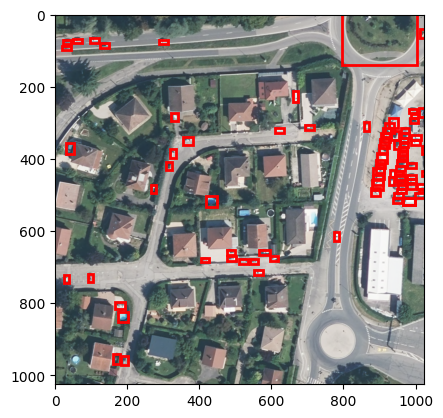

In [102]:
import math
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(img_tif.astype("uint8"))

# Add the bounding boxes
list_aabb_bbox = []
for box in annotations:
    obb = box["coordinates"]
    x_min,y_min,x_max,y_max = obb_to_aabb(obb)
    x_min,y_min,x_max,y_max = math.ceil(x_min),math.ceil(y_min),math.ceil(x_max),math.ceil(y_max)
    list_aabb_bbox.append([x_min,y_min,x_max,y_max])
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Display the plot
plt.show()

#### Send request with the bbox prompts to SAM API

In [103]:
data = {
    "list_images": [
        {
            "image_name": os.path.basename(example_tif_s3),
            "image_uri": example_tif_s3,
            "bboxes": list_aabb_bbox,
            "points": None,
            "labels": None
        },
    ]
}
response = requests.post(os.path.join(sam_api,"api/v1/prompt"),headers=headers,json=data)
print (response.text)
task_id = json.loads(response.content.decode())

{"task_id":"00a84ffc-f4ec-43d3-8be8-6731a7cfd9bb"}


#### Monitor the task status

In [105]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(sam_api,"api/v1/task/status"), headers=headers, params=params)
print(response.text)

{"task_id":"00a84ffc-f4ec-43d3-8be8-6731a7cfd9bb","state":"SUCCESS","result":"[{'image_uri': 's3://MoBucket/yolov8-od/patch_520.tif', 'processed': True, 'png_result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/00a84ffc-f4ec-43d3-8be8-6731a7cfd9bb/patch_520_bbox_mask.png?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=hDY8MqMS6HdU4FtHfQQRs06%2Bu4g%3D&Expires=1716831661', 'png_result_uri': 's3://MoBucket/00a84ffc-f4ec-43d3-8be8-6731a7cfd9bb/patch_520_bbox_mask.png', 'tif_result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/00a84ffc-f4ec-43d3-8be8-6731a7cfd9bb/patch_520_bbox_mask.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=dhGCHgVptGpwkc%2F10qM2SkfZj1E%3D&Expires=1716831661', 'tif_result_uri': 's3://MoBucket/00a84ffc-f4ec-43d3-8be8-6731a7cfd9bb/patch_520_bbox_mask.tif'}]"}


#### Get results

In [106]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(sam_api,"api/v1/prompt"), headers=headers, params=params)
results = response.json()
print (results)

{'results': [{'image_uri': 's3://MoBucket/yolov8-od/patch_520.tif', 'processed': True, 'png_result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/00a84ffc-f4ec-43d3-8be8-6731a7cfd9bb/patch_520_bbox_mask.png?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=hDY8MqMS6HdU4FtHfQQRs06%2Bu4g%3D&Expires=1716831661', 'png_result_uri': 's3://MoBucket/00a84ffc-f4ec-43d3-8be8-6731a7cfd9bb/patch_520_bbox_mask.png', 'tif_result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/00a84ffc-f4ec-43d3-8be8-6731a7cfd9bb/patch_520_bbox_mask.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=dhGCHgVptGpwkc%2F10qM2SkfZj1E%3D&Expires=1716831661', 'tif_result_uri': 's3://MoBucket/00a84ffc-f4ec-43d3-8be8-6731a7cfd9bb/patch_520_bbox_mask.tif'}]}


#### Save results to local file

In [107]:
sam_output_tif_path = os.path.join(segmentation_output_path,"prompt_mask_patch_520.tif")
save_image_from_url(results["results"][0]["tif_result_url"],sam_output_tif_path)

Image successfully saved to data/object_detection/sam_segmentation/prompt_mask_patch_520.tif


#### Visualize results

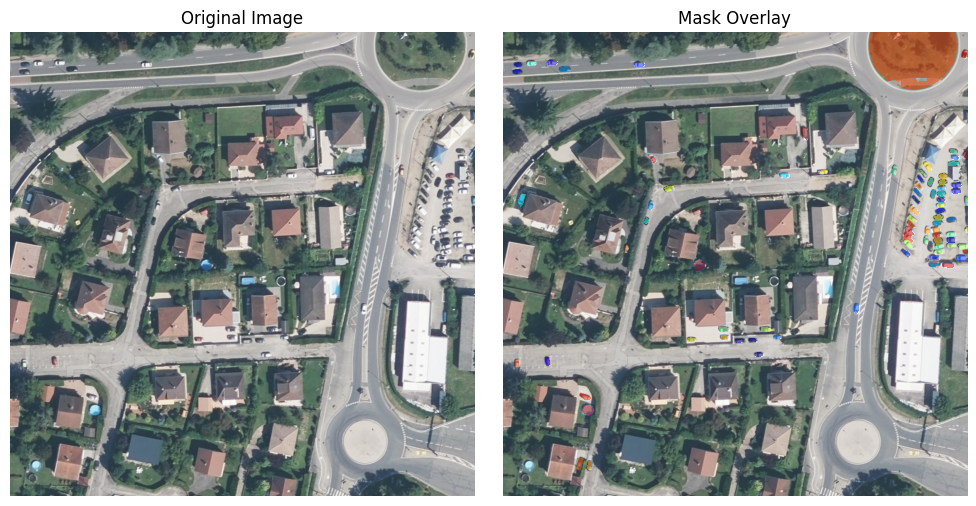

In [110]:
msk_img = tiff.imread(sam_output_tif_path)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_tif.astype("uint8"))
plt.axis('off')
plt.title('Original Image')
msk_img[msk_img==0] = np.nan
plt.subplot(1, 2, 2)
plt.imshow(img_tif.astype("uint8"))
plt.imshow(msk_img, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Mask Overlay')
plt.tight_layout()
plt.show()